In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd

## boilerplate that reduces the number of rows pandas outputs
## makes display cleaner
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', None)

## Read in the data 


In [ ]:
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text

In [ ]:
train_data = pd.read_csv('census.train', converters={'education' : strip,
                                    'marital-status' : strip,
                                    'occupation' : strip,
                                    'race' : strip,
                                    'sex' : strip,
                                    'hours-per-week' : strip,
                                    'prediction' : strip})

test_data = pd.read_csv('census.test', converters={'education' : strip,
                                    'marital-status' : strip,
                                    'occupation' : strip,
                                    'race' : strip,
                                    'sex' : strip,
                                    'hours-per-week' : strip,
                                    'prediction' : strip})
train_data = train_data.drop(['Unnamed: 0'], axis=1)
test_data = test_data.drop(['Unnamed: 0'], axis=1)
train_data

In [ ]:
income_boundary = train_data['prediction']
y = np.where(income_boundary == '<=50K',1,0)
train_data = train_data.drop(['prediction'], axis=1)

# We don't need these columns
# to_drop = ['State','Area Code','Phone','Churn?']
# churn_feat_space = churn_df.drop(to_drop,axis=1)

## Understanding the data
Before working with a dataset, I spend a little bit of time trying to figure out the different aspects of the dataset. I'll glimpse through the table and get an idea of what types of variables are being represented, some of the possible values, etc. One of the first things I investigate is the number of unique values in each column

In [ ]:
# iteratie through the columns and count the unique values in each column
for column in train_data:
    print(column, len(np.unique(train_data[column])))

This gives me a few insights about what techniques may be best for processing the data. For example, we now see that sex clearly has only two categories, therefore we'd definitely only want 1 feature to represent sex.

## Dealing with categorical Data
Before we can even get close to framing this problem in a proper context, we need to deal with the categorical data. 





There are a number of techniques to approach this and each varies based on the type of data. 

The simplest of technique is to enumerate all possible categories and replace the categories with their numerical position. Fortunately, sklearn has the module just for us: [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)


Let's start with the simple case - sex

In [ ]:
from sklearn.preprocessing import LabelEncoder as LE

num_encoder = LE()
encoded_train_data = train_data.copy()
#to convert into numbers
print('before encoding', np.unique(train_data['sex']))
encoded_train_data['sex'] = num_encoder.fit_transform(train_data['sex'])
print('after encoding', np.unique(encoded_train_data['sex']))

Of course we will want to do the same for the other categorical variables. **Write a function that does this for a given list of column names**

In [ ]:
def le_categories(df, labels):
    # test to make sure labels are in dataframe
    assert set(labels).issubset(df.columns), "Labels not in column names"
    encoded_df = df.copy()
    ### STUDENT SOL START ###
    for label in labels:
        encoder = LE()
        encoded_df[label] = encoder.fit_transform(encoded_df[label])
    ### STUDENT SOL END ###
    return encoded_df
le_categories(train_data, ['sex', 'education', 'marital-status', 'occupation', 'race', ])

### There's another way (and it's sometimes better!)
Another technique to encode categorical data is called **One Hot Encoding**. Essentially, you're taking every possible category for a catgorical feature and making it it's own binary feature. 

One hot encoding can improve performance of a classifier by removing the notion of order the enumerated labels produced by labelencoding can include. Despite adding more features and thereby reducing performance, other techniques exist to offset this loss. Now let's try this out with marital status

In [ ]:
# reset the data to undo the stuff we did in LE

In [ ]:
#OHE EXAMPLE
from sklearn.preprocessing import OneHotEncoder as OHE


marstat_unique = np.unique(train_data['marital-status'])
# sklearn One hot encoder only deals with numbers, so we run LE first 
encoded_train_data = le_categories(train_data, ['marital-status'])
ohe_encoder = OHE()
# enc.transform(['Male'])
ohe_encoder.fit(encoded_train_data['marital-status'].reshape(-1, 1))
# check number of values found
ohe_encoder.n_values_[0]

In [ ]:
# transform simply takes the columnar Gender data, then returns the OneHotEncoded matrix
marstat_ohe = ohe_encoder.transform(encoded_train_data['marital-status'].reshape(-1, 1)).toarray()

df = pd.DataFrame(marstat_ohe, dtype=np.int, columns=marstat_unique)
df

Now let's join the two together 

In [ ]:
# encoded_train_data = encoded_train_data.drop(['marital-status'], axis=1)
encoded_train_data = encoded_train_data.join(df)
encoded_train_data

**Adopt the above example to work for a dataframe when given a list of column names**

In [ ]:

def ohe_catgories(df, labels):
    assert set(labels).issubset(df.columns), "Labels not in column names"
    encoded_train_data = train_data
    ### STUDENT SOL START ###
    
    ### STUDENT SOL END ###
ohe_categories(train_data, ['sex', 'education', 'marital-status', 'occupation', 'race'])

There you go! Now you have two excellent techniques that you can use to convert pesky categorical data into something your classifier will *love*. 

Choosing which method to use is up to you, but here are a few caveats to help make your decision easier:

* Label encoding does bake in a notion of distance. This means that this method is best for categorical data with a notion of order.
* If there is no notion of order, it's probably better to use one hot encoding as this better reflects the proper hamming distance (aka similarity) you'd expect for datapoints with such a label
* One hot encoding comes with the trade off of increased dimensionality, which can quickly increase the amount of time your algorithm takes to train. This is especially prevalent with categorical data that has many categories - such as occupation in this dataset.

## Moving On - Binning
Now that we've explored categorical data, we can do some tricks to improve performance using continuous data as well. 

A popular and useful technique is called binning. The procedure involves breaking up a range of continuous numbers into equally sized chunks, then assigning each datapoint to their respective chunk. This significantly reduces the number of possible values that an algorithm needs to handle, oftentimes leading to significant accuracy increases. [This stackexchange answer](http://stats.stackexchange.com/questions/143806/why-binning-variables-in-predictive-analytics) runs through a few situations where binning may be beneficial.

Let's try this out with the age column in our data. Pandas provides a simple method for binning data using the `cut` function

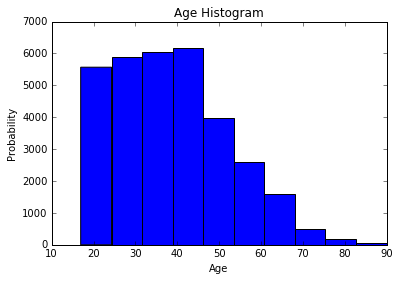

In [54]:
# we'll start by analyzing the properties of the data 
age_feature = train_data['age']
binned_column, bins = pd.cut(age_feature, bins=10, labels=False, retbins=True)
plt.xlabel('Age')
plt.ylabel('Probability')
plt.title('Age Histogram')
plt.hist(age_feature, bins=bins) # you can switch this out with np.histogram, but it won't plot that way
plt.show()   


Now, after playing around with the data, we can use pandas `cut` function to do this for us

In [ ]:
train_data['age_binned'] = binned_column
train_data

In [ ]:
train_data.columns